# **Data feature Engineering Notebook**

## Objectives
- prepare data for ML pipeline
- Engineer features for Classification, Regression and Cluster models

## Inputs
- outputs/data_cleaned/TestSet.csv
- outputs/data_cleaned/TrainSet.csv

## Outputs
- Generate a list with varables to engineer: outputs/data_feature_engine/house_prive_data_fe.csv

## Conclusion
- Data pipeline
- Feature Engineering Transformers
  - Ordinal categorical encoding ...
  - Smart Correlation Selection ...


---

## Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/ci-c5-housing-market-prices/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/ci-c5-housing-market-prices'

---

## Load cleaned data

TrainSet

In [4]:
import pandas as pd
train_set_path = "outputs/data_cleaned/TrainSet.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

,1stFlrSF,2ndFlrSF,BsmtFinSF1,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotFrontage,MasVnrArea,OpenPorchSF,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,1682,0.0,0,530,1,1970.0,1682,2,80.0,288.0,0,7,1304,1970,1970,174000
1,1072,0.0,547,525,3,2005.0,1072,2,35.0,80.0,28,5,547,2005,2005,145000
2,764,783.0,24,614,1,2009.0,1547,3,72.0,0.0,45,7,756,2009,2009,215200


Test Set

In [5]:
import pandas as pd
test_set_path = "outputs/data_cleaned/TestSet.csv"
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

,1stFlrSF,2ndFlrSF,BsmtFinSF1,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotFrontage,MasVnrArea,OpenPorchSF,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,1068,0.0,663,264,2,1963.0,1068,2,70.0,0.0,0,6,1059,1963,2003,154500
1,1500,0.0,1032,712,2,1994.0,2622,3,98.0,362.0,32,8,1463,1994,1995,325000
2,1028,0.0,0,360,1,1927.0,1028,2,56.0,0.0,0,5,1008,1927,1950,115000


## Data Exploration

Evalation which potential transformation could be done in the variables

In [7]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Feature Engineering

### Custom function
Based on custom function in the feature-engine lesson. That will help with the feature engineering process.

In [9]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

### Numerical Transformation

Step 1: Select variable(s)

In [6]:
variables_engineering = ['SalePrice', 'GrLivArea', 'GarageArea']
variables_engineering 

['SalePrice', 'GrLivArea', 'GarageArea']

Step 2: Create a separate DataFrame, with the relevant variable(s)

In [7]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

,SalePrice,GrLivArea,GarageArea
0,174000,1682,530
1,145000,1072,525
2,215200,1547,614


Step 3: Create engineered variable(s) by applying the transformation(s), assess engineered variables distribution and select the most suitable method

* Variable Analyzed: SalePrice
* Applied transformation: ['SalePrice_log_e', 'SalePrice_log_10', 'SalePrice_reciprocal', 'SalePrice_power', 'SalePrice_box_cox', 'SalePrice_yeo_johnson'] 



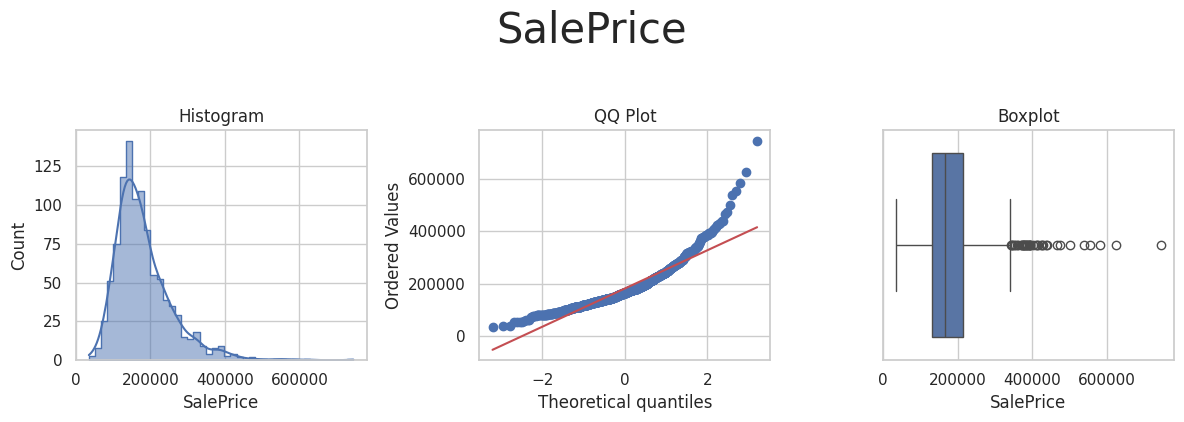

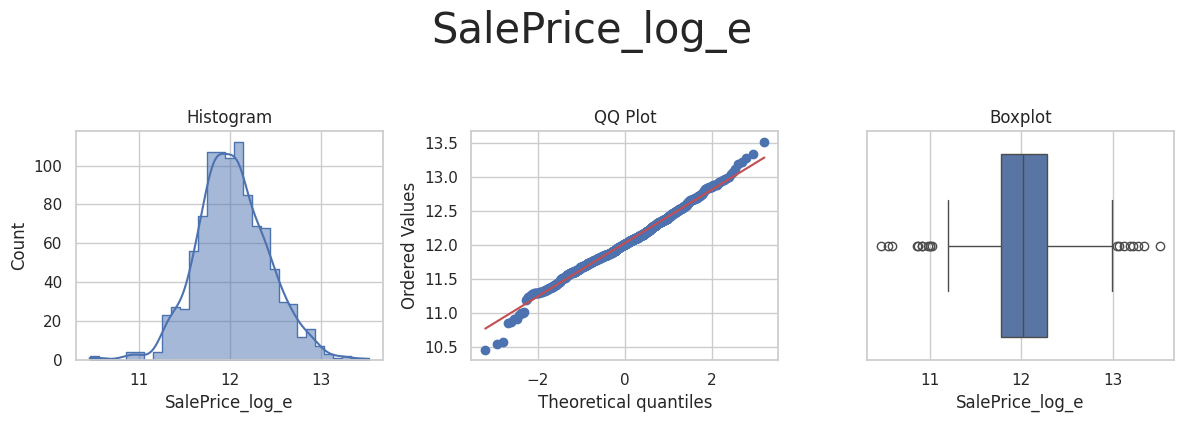

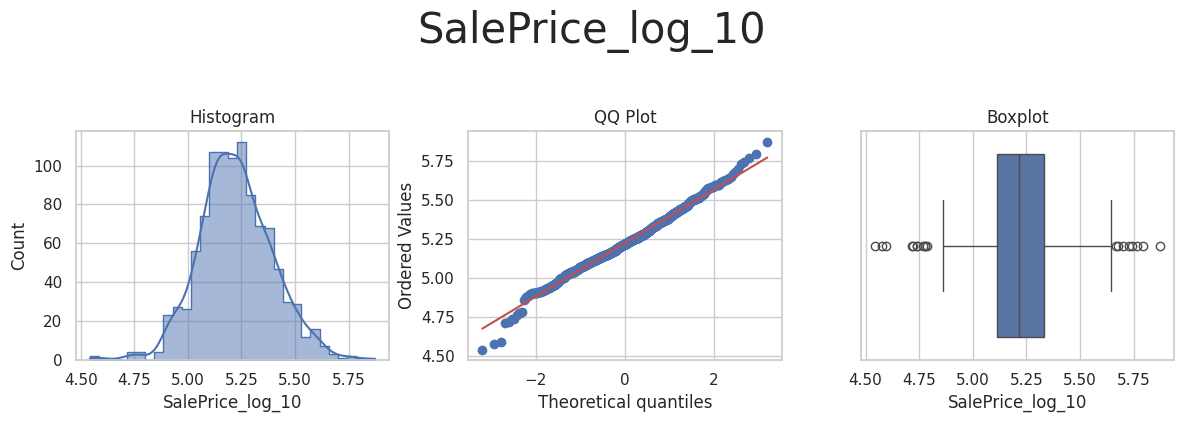

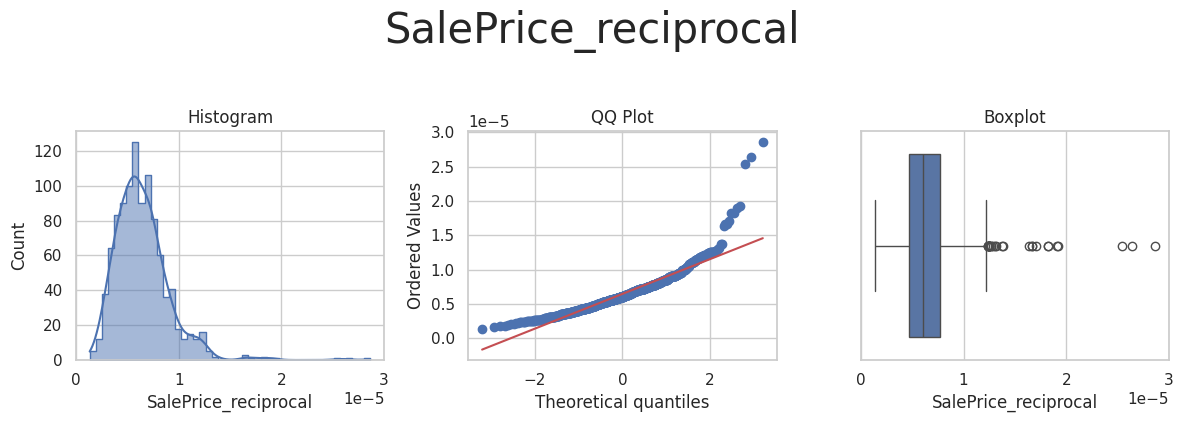

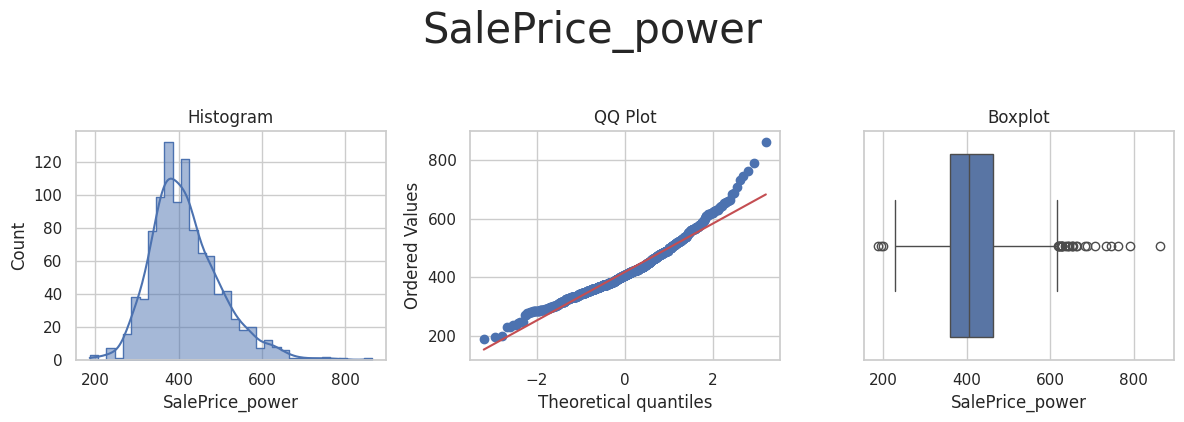

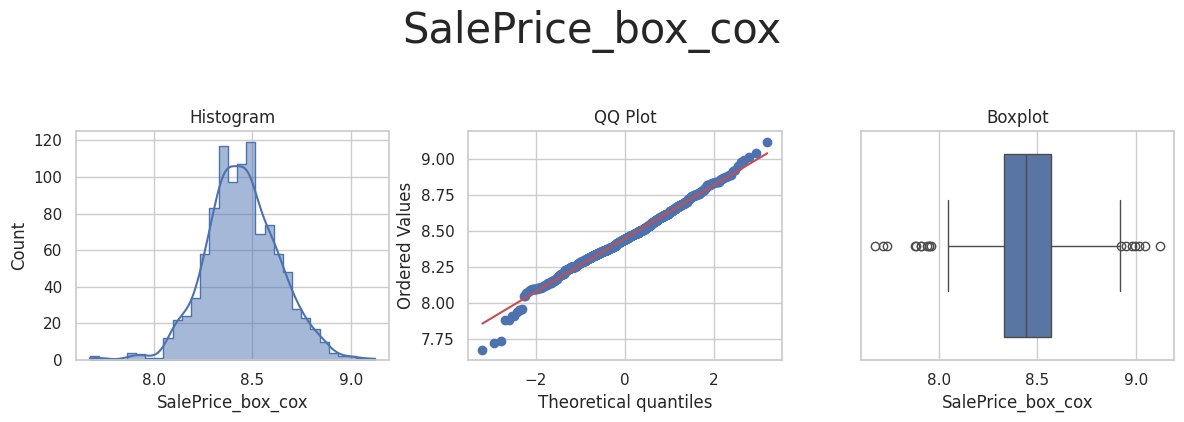

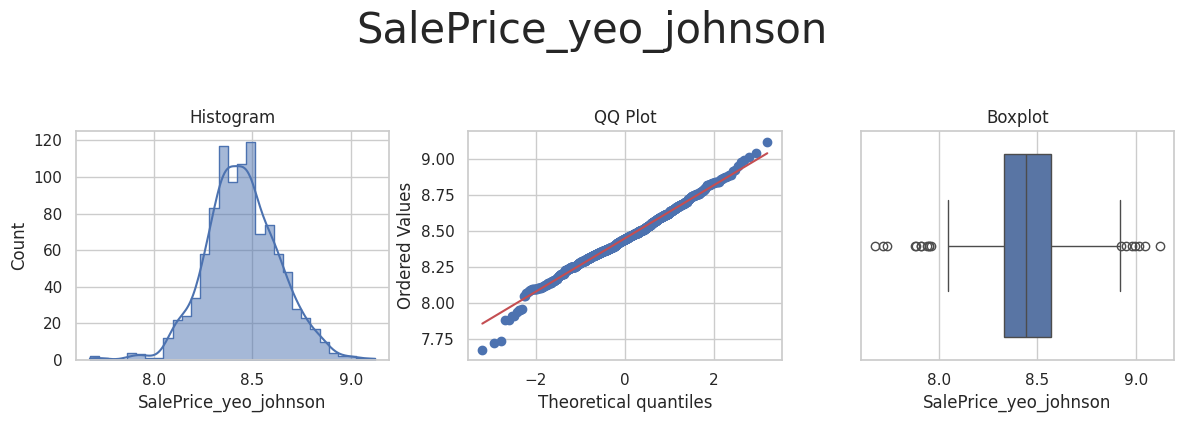



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



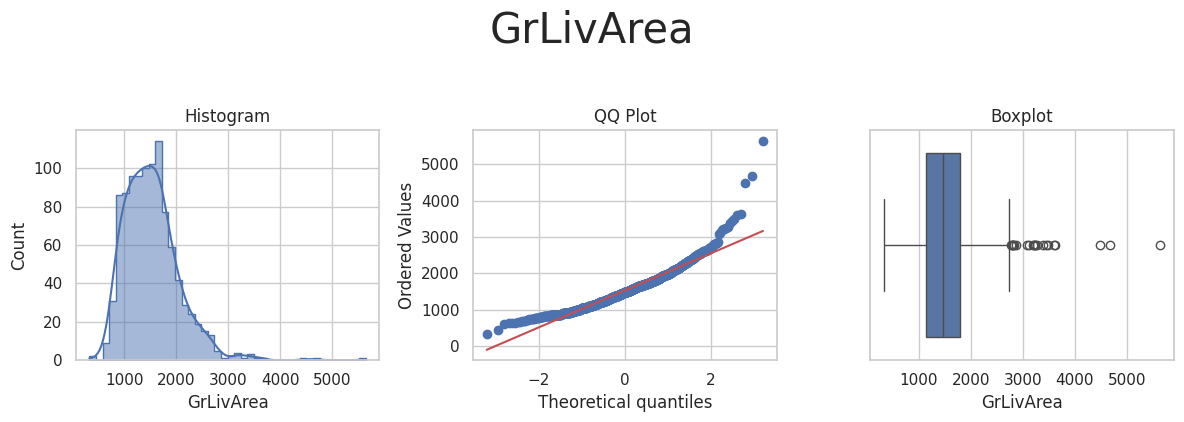

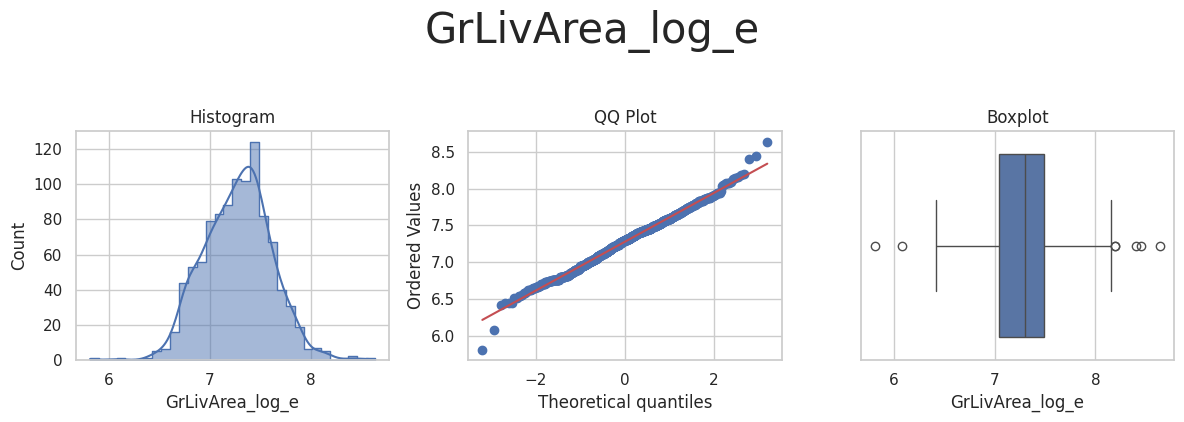

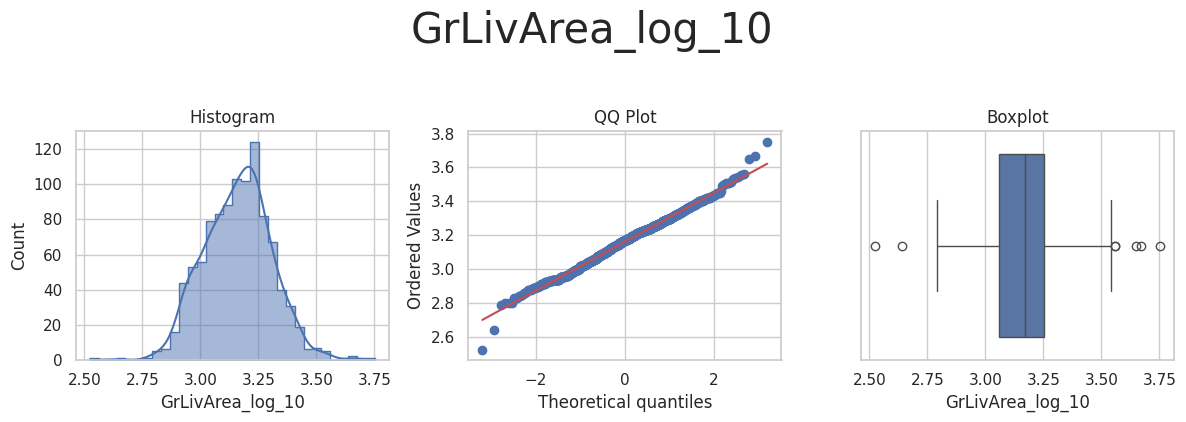

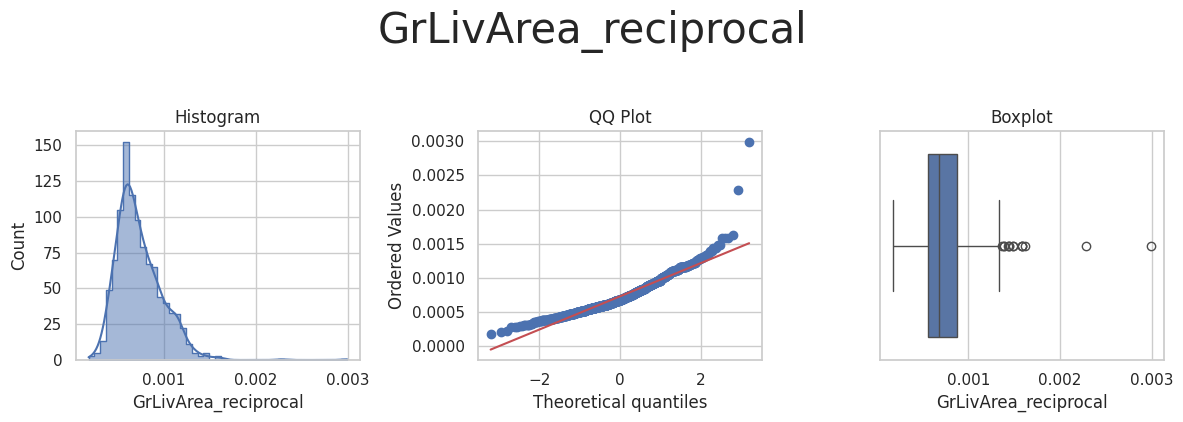

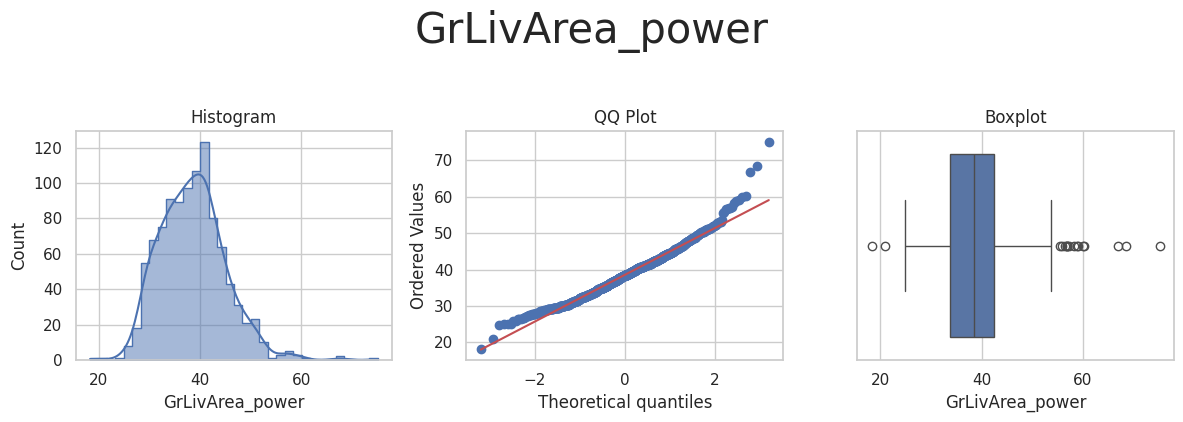

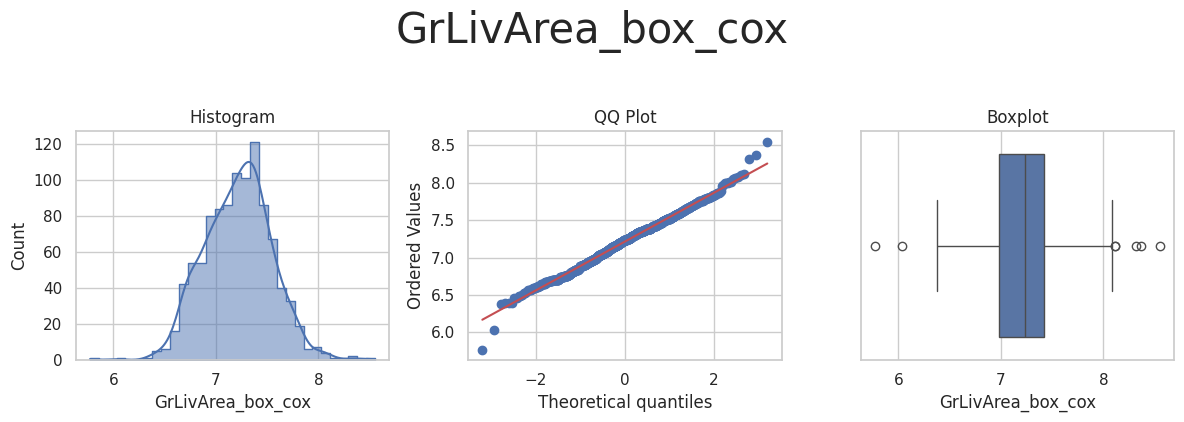

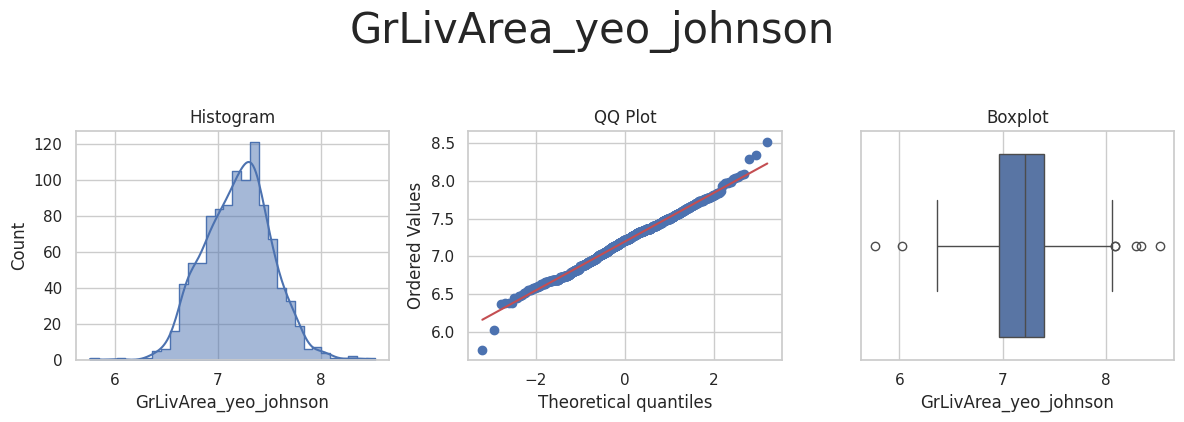



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson'] 



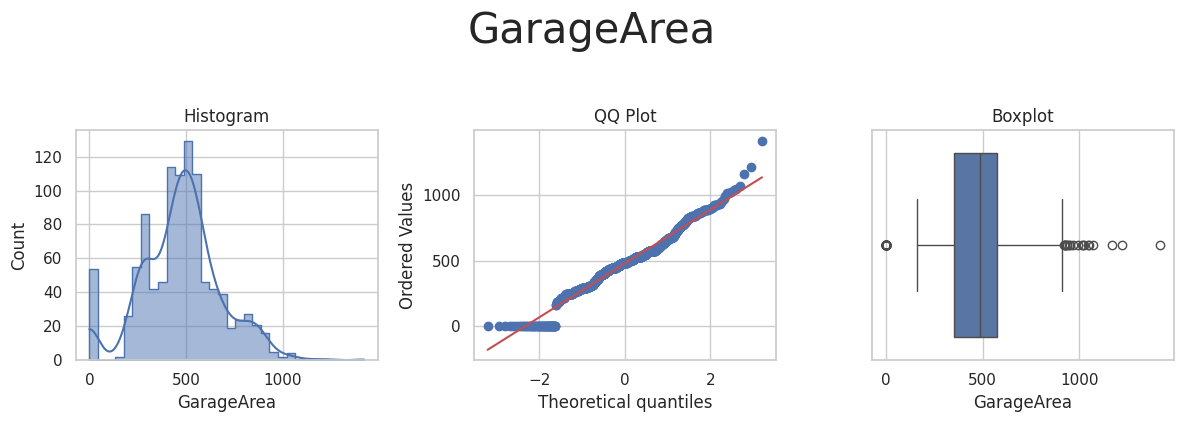

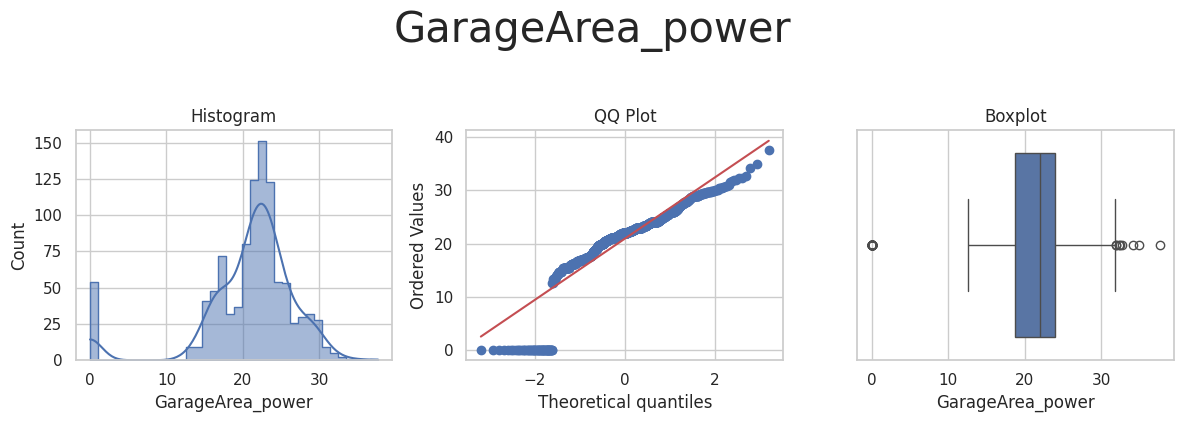

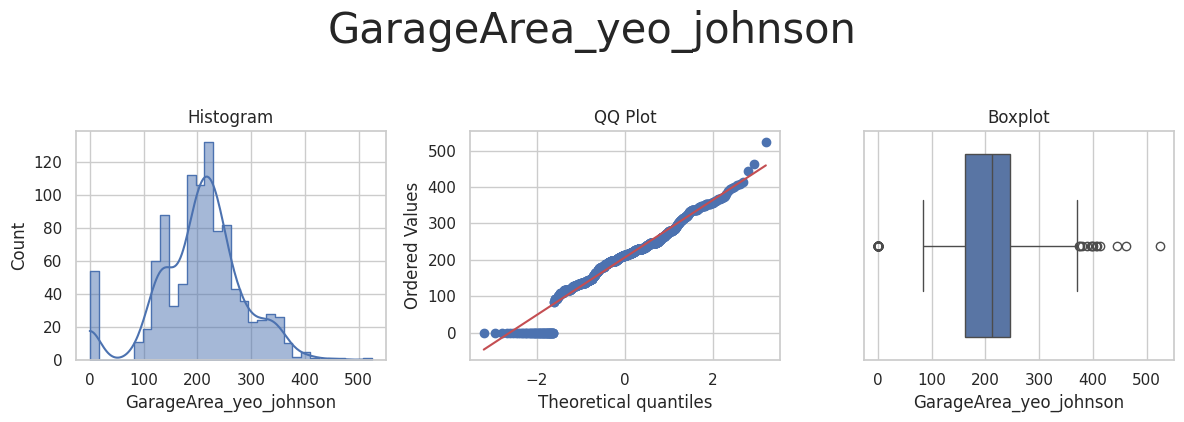

In [10]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

* For each variable, write your conclusion on how the transformation(s) look(s) to be effective
  * For all variables - it didn't improve the boxplot distribution or qq plot))

Step 4: Apply the selected transformation to the Train and Test set

### SmartCorrelated Selection Variable(s)

Step 1: Select variable(s)

In [12]:
variables_engineering = ['TotalBsmtSF', '1stFlrSF', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'BsmtFinSF1', 'LotFrontage', '2ndFlrSF', 'OpenPorchSF']
variables_engineering

['TotalBsmtSF',
 '1stFlrSF',
 'YearRemodAdd',
 'GarageYrBlt',
 'MasVnrArea',
 'BsmtFinSF1',
 'LotFrontage',
 '2ndFlrSF',
 'OpenPorchSF']

Step 2: Create a separated DataFrame with the relevant variable(s)

In [13]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

,TotalBsmtSF,1stFlrSF,YearRemodAdd,GarageYrBlt,MasVnrArea,BsmtFinSF1,LotFrontage,2ndFlrSF,OpenPorchSF
0,1304,1682,1970,1970.0,288.0,0,80.0,0.0,0
1,547,1072,2005,2005.0,80.0,547,35.0,0.0,28
2,756,764,2009,2009.0,0.0,24,72.0,783.0,45


Step 3: Create engineered variable(s) applying the transformation(s)

In [14]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_

[{'1stFlrSF', 'TotalBsmtSF'}, {'GarageYrBlt', 'YearRemodAdd'}]

In [15]:
corr_sel.features_to_drop_

['1stFlrSF', 'YearRemodAdd']

---

## Conclusion

The list below shows the transformations needed for feature engineering.
  * These steps are added to the ML Pipeline